## In this notebook test code from BP_utils.py for taking numpy arrays of images and masks and creating combined ultrasound image, mask, and an dummy classifier decision bounday

## these arrays were generated using code from:
https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [62]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import os  
import sys
import cv2

In [63]:
# load the BP_utils.py script
os.chdir('/Users/afinneg2/BP_identification')
cwd=os.getcwd()
print cwd
print os.listdir(cwd)
os.chdir('scripts')
#import BP_utils
reload(BP_utils)
os.chdir(cwd)

/Users/afinneg2/BP_identification
['.ipynb_checkpoints', 'analysis_notebooks', 'commands.bash', 'data', 'documents', 'imgs_id_test.npy', 'imgs_mask_train.npy', 'imgs_test.npy', 'imgs_train.npy', 'mnist_data', 'networks', 'PCA_analysis', 'raw', 'scratch', 'scripts', 'TrainValidPartitions']


In [64]:
# load training data
train_imgs= np.load('imgs_train.npy')
print 'shape train_imgs {}'.format(np.shape(train_imgs))
train_masks = np.load('imgs_mask_train.npy')
print 'shape train_mask {}'.format(np.shape(train_masks))

shape train_imgs (5635, 1, 420, 580)
shape train_mask (5635, 1, 420, 580)


In [65]:
print "size of train_imgs is"
print "{} GB".format(sys.getsizeof(train_imgs)/(10.0)**9)

size of train_imgs is
1.372686144 GB


In [66]:
## temporarily shorten the array of training_imgs 
num_imgs=100
train_imgs=train_imgs[0:num_imgs]
train_masks=train_masks[0:num_imgs]

#  Demonstrate some methods for plotting images and masks

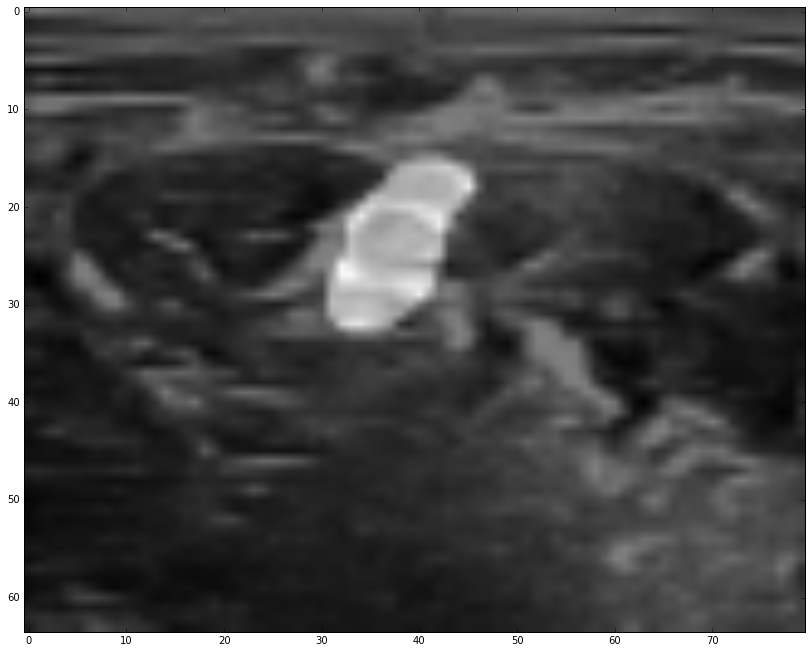

In [65]:
# method 1 overlay the image with a transparent represention of the corresponding mask
# we do this for training example 6
%matplotlib inline
fig_size=(14.,14.)

fig=plt.figure(figsize=(fig_size))
ax= fig.add_subplot('111')
ax.imshow(train_imgs[0], cmap='gray')
ax.imshow(train_masks[0], cmap='gray',alpha=0.5)

In [1]:
%matplotlib inline
## method 2 plot the image and the bounday of the maske using the 
## function BP_utils.plot_mask_with_decision_bndry
## to add the training image 6 and the outline of training mask 6 to
## to the axis object ax
img_num=11


fig=plt.figure(figsize=(14.,14.))
ax=fig.add_subplot('111')
ax=BP_utils.plot_mask_with_decision_bndry(ax, train_imgs[img_num,0],
                                          train_masks[img_num,0])


NameError: name 'plt' is not defined

In [ ]:
## method 3 plot image mask boundary and dummy decision boundary
## the decision boundary is a tuple of arrays of xvals and yvals
## this is the assumed output of the cl assifier.
fig= BP_utils.plot_example(train_imgs[6,0],train_masks[6,0])

# The image space is  420x 580  (~243,000 ) dimensional (too large). Cov net efforts on Kaggle use cv2 to reduce the image size.

Below we reduce the image to (64,80) (these are dimensions used by M Jocic's kaggle tutorial)

In [ ]:
%matplotlib inline
interp_method='INTER_AREA'

#plot a sample
BP_utils.plot_image(train_imgs[0,0], title='full image')

resized_rows = 64
resized_cols= 80
BP_utils.plot_image( 
    BP_utils.resize_images(train_imgs[0:1],resized_rows, resized_cols, interp_method)[0,0]
                     , title ='resized {} by {}'.format(resized_rows, resized_cols)
                            )
resized_rows = 84
resized_cols= 116
BP_utils.plot_image( 
    BP_utils.resize_images(train_imgs[0:1],resized_rows, resized_cols, interp_method)[0,0]
                     , title ='resized {} by {}'.format(resized_rows, resized_cols)
                )

# Rescale the training images to 64 by 80 and do local PCA
Proceedure:
+ resize
+ mean center and scale by 1/255.0 (pixel intensity rage is 0, 255)
+ do PCA in sliding windows of size (?) (choose (8,10))
+ get distributions of image projections along PC vects with highest variance
+ assess difference between projections of positive and negative classes onto a PC vec using Jenson Shannon divergence

In [6]:
# resize
resized_rows = 64
resized_cols= 80
interp_method ='INTER_AREA'

train_imgs = BP_utils.resize_images(train_imgs,
                        resized_rows, resized_cols, interp_method='INTER_AREA')
train_masks = BP_utils.resize_images(train_masks,
                        resized_rows, resized_cols, interp_method='INTER_AREA')

train_imgs = np.squeeze(train_imgs, axis=1)
train_masks =np.squeeze(train_masks, axis=1)

train_imgs_mean = np.mean(train_imgs, axis=0)
train_imgs_scale = 1/255.0
mean_standard_train = train_imgs*train_imgs_scale -  train_imgs_mean*train_imgs_scale


print "shape of training imgaes {}".format(np.shape(train_imgs))
print np.shape(train_masks)

In [8]:
print np.shape(train_imgs)
print np.shape(train_masks)

(400, 64, 80)
(400, 64, 80)


In [7]:
# mean center and standardize by max grey scale intensity 255
train_imgs_mean = np.mean(train_imgs, axis=0)
train_imgs_scale = 1/255.0
mean_standard_train = train_imgs*train_imgs_scale -  train_imgs_mean*train_imgs_scale

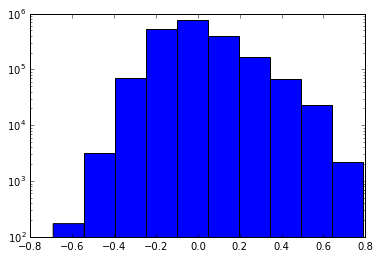

In [9]:
%matplotlib inline
plt.hist(np.ravel(mean_standard_train))
plt.yscale('log')

In [10]:
# do the PCA
local_PCA_window =(8,10)
stride=(2,2)
nb_largest_ev=10

local_PCA_evals , local_PCA_evecs = BP_utils.local_PCA(mean_standard_train, 
                                                      window= local_PCA_window,
                                                      stride=stride,
                                                      nb_largest_ev=nb_largest_ev)

img_rows 64
img_cols 80
output_arr_dims (29, 36)


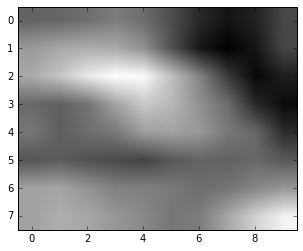

In [46]:
plt.imshow(local_PCA_evecs[14,17,:,0].reshape(8,10), cmap='gray')

In [11]:
## get indices of images positive for BP
pos_mask = np.asarray([BP_utils.mask_not_blank(mask) for mask in train_masks])
neg_mask = np.logical_not(pos_mask)

In [12]:
print np.shape(pos_mask)
print np.shape(neg_mask)

(400,)
(400,)


In [40]:
# to get an idea of shape distributions of positive and negative imges projected onto
# PC vectors plot an example of this distribution
pos_hists_arr, neg_hists_arr = BP_utils.make_PCvec_score_distributions(
                                                local_PCA_evecs[14,17,:,:],
                                                mean_standard_train[pos_mask],
                                                mean_standard_train[neg_mask],
                                                window = (8,10), proj_bins=10)

In [41]:
print np.shape(pos_hists_arr)
print np.shape(neg_hists_arr)

(57, 71, 10, 10)
(57, 71, 10, 10)


16.0
24.0


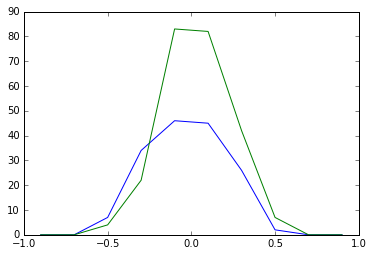

In [45]:
%matplotlib inline
proj_bins = 10
bin_edges =np.linspace(-1,1,proj_bins+1)
plt.figure()
plt.plot(0.5*(bin_edges[1:] + bin_edges[:-1]) , pos_hists_arr[30,40,:,4])
plt.plot(0.5*(bin_edges[1:] + bin_edges[:-1]) , neg_hists_arr[30,40,:,4])
print np.mean(pos_hists_arr[30,40,:,0])
print np.mean(neg_hists_arr[30,40,:,0])

Conclusions:
+ We decide to nomalized windows of images before projecting onto vectors so that the returned projection is in [-1,1]
+ for this range using 10 bins gives rough description of the distribution while avoiding bins with 0 counts which would cause unwanted fluctuations in JS divergence calculation

So use 10 bins for describing the distribtion of image projections

In [47]:
# for a set of PC vecs get the distribution of Jenson-Shannon divergences of the 
# distributions of positive and negtive class images projected onto the pc vec
# at different sliding window locatios in image
JS_D_arr=BP_utils.calculate_JS_div_along_PCvecs(local_PCA_evecs[14,17,:,:],
                                                mean_standard_train[pos_mask],
                                                mean_standard_train[neg_mask],
                                                window = (8,10), proj_bins=10)

In [48]:
print np.shape(local_PCA_evecs)
print np.shape(JS_D_arr)

(29, 36, 80, 10)
(57, 71, 10)


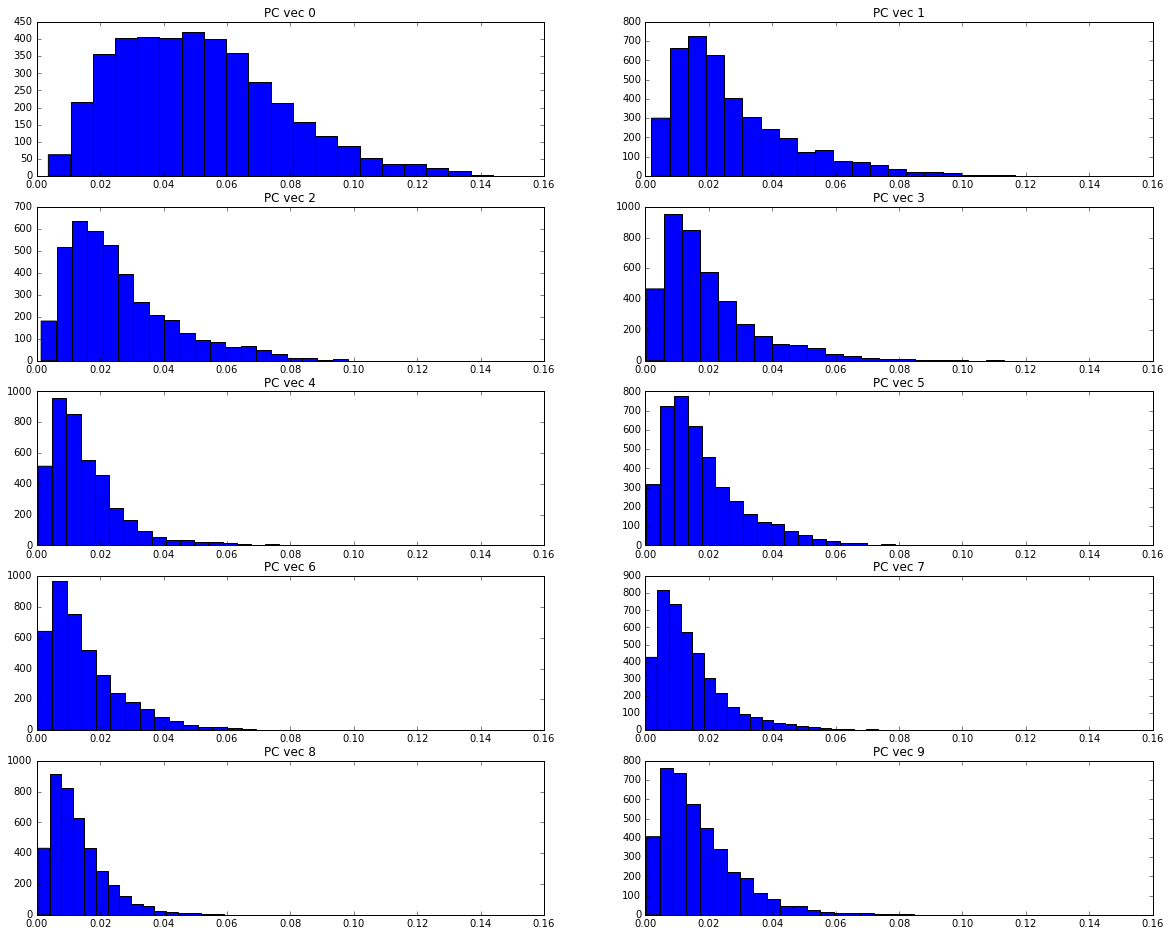

In [53]:
%matplotlib inline
plt.figure(figsize=(20.,16.))
for i in xrange(0,10):
    plt.subplot(5,2,i+1)
    plt.hist(np.ravel(JS_D_arr[:,:,i]),bins=20)
    plt.title('PC vec {}'.format(i))
    plt.xlim(0.00,0.16)

In [62]:
# for a set of PC vecs get the distribution of Jenson-Shannon divergences of the 
# distributions of positive and negtive class images projected onto the pc vec
# at different sliding window locatios in image
JS_D_arr=BP_utils.calculate_JS_div_along_PCvecs(local_PCA_evecs[14,17,:,:],
                                                mean_standard_train[pos_mask][:,4:24,7:27],
                                                mean_standard_train[neg_mask][:,4:24,7:27],
                                                window = (8,10), proj_bins=10)

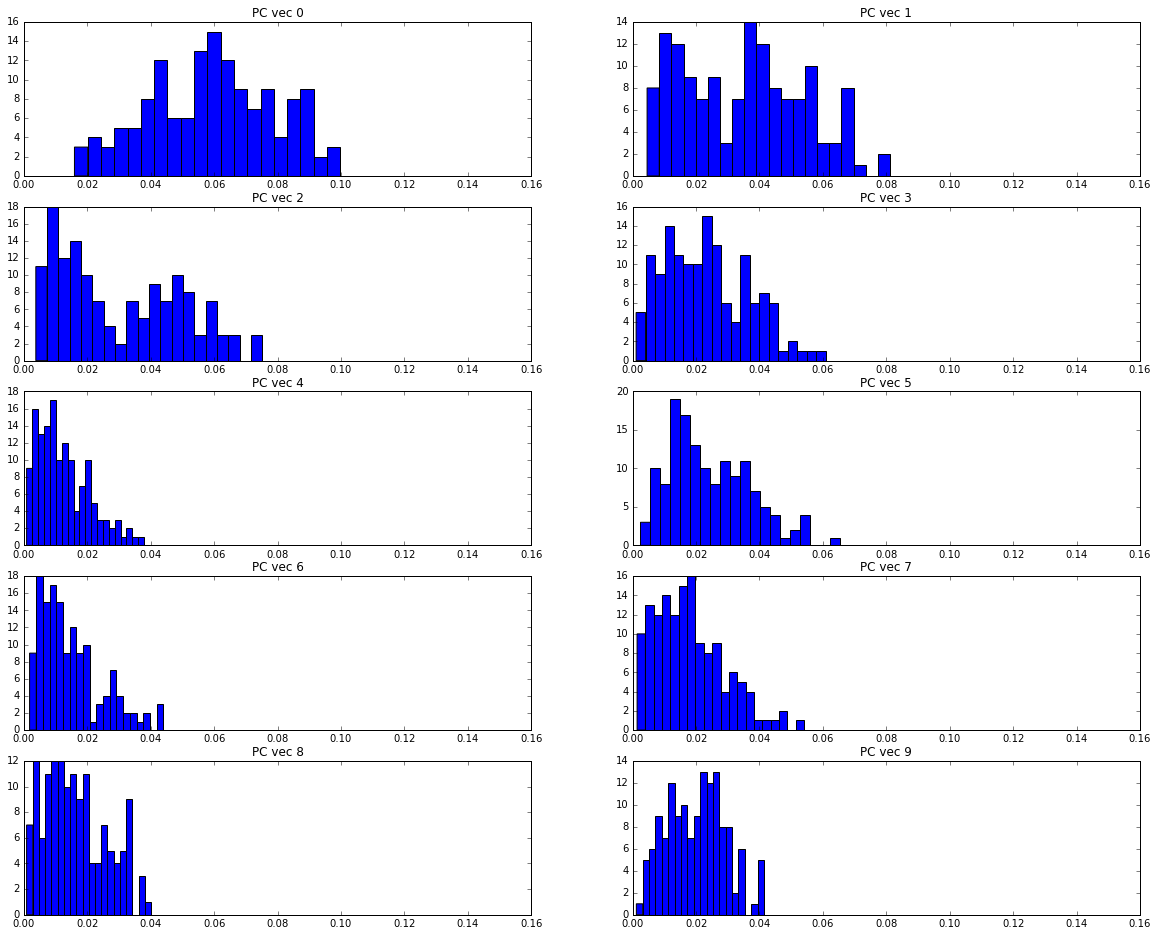

In [63]:
%matplotlib inline
plt.figure(figsize=(20.,16.))
for i in xrange(0,10):
    plt.subplot(5,2,i+1)
    plt.hist(np.ravel(JS_D_arr[:,:,i]),bins=20)
    plt.title('PC vec {}'.format(i))
    plt.xlim(0.00,0.16)

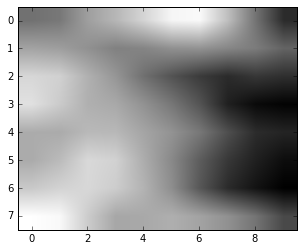

In [59]:
plt.imshow(local_PCA_evecs[10,17,:,0].reshape(8,10), cmap='gray')

# We aim to build the network architechure illustrated below

           (classification layer)
              |
              |
           (fully connected layer)  (?)
             |
             |
           (fully connected layer)
            |               |
            x               |
            |        (Cov Layer ) x2 ?
            x               |
            |               |
           (     inputs           )
            
            
The  -x-x- weights will be initialized from PC decomposition of the images to proved a semisuperivision of the learning of the cov layers

## Below we get the following PC devompositions for initialization of these weights
+ PC decomposition of the full image

In [54]:
# resize and preprocess
resized_rows = 64
resized_cols= 80
interp_method ='INTER_AREA'

train_imgs = BP_utils.resize_images(train_imgs,
                        resized_rows, resized_cols, interp_method='INTER_AREA')
train_masks = BP_utils.resize_images(train_masks,
                        resized_rows, resized_cols, interp_method='INTER_AREA')

train_imgs = np.squeeze(train_imgs, axis=1)
train_masks =np.squeeze(train_masks, axis=1)

train_imgs_mean = np.mean(train_imgs, axis=0)
train_imgs_scale = 1/255.0    
mean_standard_train = train_imgs*train_imgs_scale -  train_imgs_mean*train_imgs_scale


print "shape of training imgaes {}".format(np.shape(train_imgs))
print np.shape(train_masks)

shape of training imgaes (5635, 64, 80)
(5635, 64, 80)


In [55]:
# do the PCA
local_PCA_window =(64,80)
stride=(2,2)
nb_largest_ev=60

local_PCA_evals , local_PCA_evecs = BP_utils.local_PCA(mean_standard_train, 
                                                      window= local_PCA_window,
                                                      stride=stride,
                                                      nb_largest_ev=nb_largest_ev)

img_rows 64
img_cols 80
output_arr_dims (1, 1)


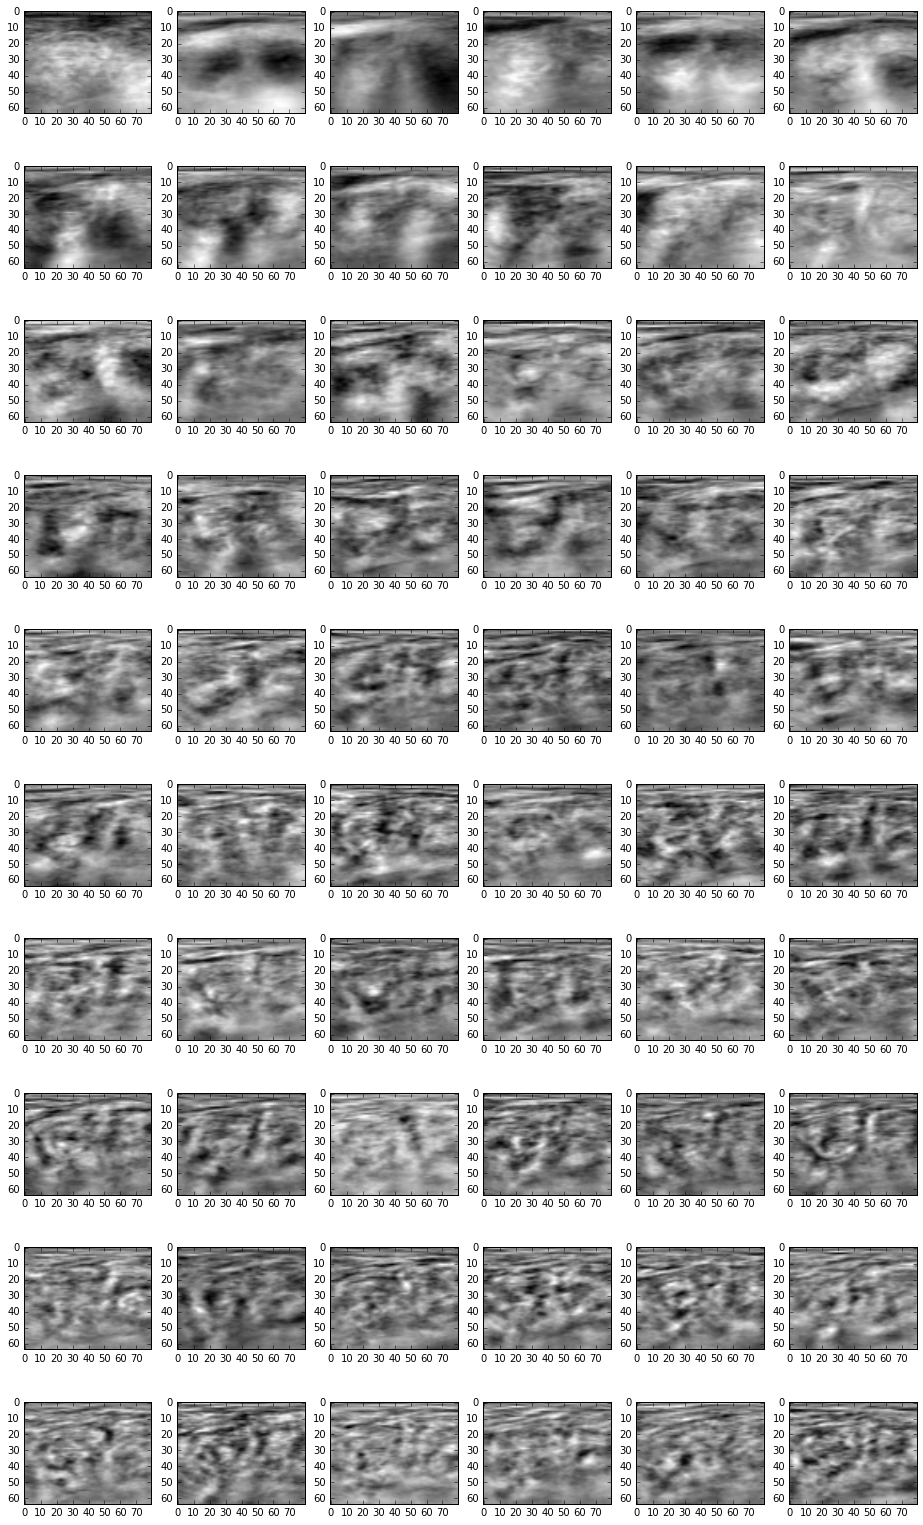

In [56]:
%matplotlib inline
nb_figs = 60
nb_cols = 6
img_size = (64,80)

plt.figure(figsize = (16.,30.))
for PC_index in xrange(0,nb_figs):
    plt.subplot((nb_figs // nb_cols) +1 , nb_cols, PC_index +1)

    plt.imshow(local_PCA_evecs[0,0,:,PC_index].reshape(img_size), cmap='gray')

(array([ 36.,  11.,   4.,   2.,   1.,   1.,   0.,   2.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.42085445,   1.00754342,   1.59423238,   2.18092135,
          2.76761031,   3.35429928,   3.94098824,   4.52767721,
          5.11436617,   5.70105514,   6.2877441 ,   6.87443307,
          7.46112203,   8.047811  ,   8.63449996,   9.22118893,
          9.80787789,  10.39456686,  10.98125582,  11.56794479,  12.15463375]),
 <a list of 20 Patch objects>)

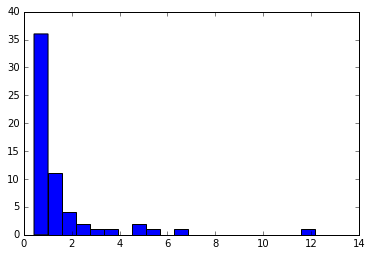

In [57]:
plt.hist(local_PCA_evals[0,0,:],bins=20)

Based on the histogram of eigen values (variance)  and the plots of PCs we decide to initialize the semisupervising weights from linear combinations of the first 30 PC vectors

In [61]:
# save the first 27 PC vectors
PCvec_fname='/Users/afinneg2/BP_identification/PCA_analysis/PCvecs_trainImgs64x80'
PCvar_fname = '/Users/afinneg2/BP_identification/PCA_analysis/PCvariances_trainImgs64x80'

## note there are two extra-dimensions in the arrays that we throw away

np.save(PCvec_fname, local_PCA_evecs[0,0,:,:])
np.save(PCvar_fname, local_PCA_evals[0,0,:])


# Still to do:
+ code to cluster PC vectors and into a number of clusters ~ number of feature maps for 1st cov layer
    + within each cluster select PC vects with highest JS divergence and save these for initializing weights for feature maps
+ Another idea is to have a "training wheels" layer with connections to the input and to the output of 1-3 conv layer (with input img as input to conv layers). The "training wheels" layer weights to input are initialized as PC vecs of image. 
    + the idea is that "training wheels" units respond, from the beginning of training, to global and relelvant features in the data. For this reason units between training wheels layer and the supervising loss wil have activation between then extemems (where vanishing gradient problem occurs). So gradients can propagate well to the cov layer between the input and training wheels layer. There gradients then supervise the learning of the conv layers so that different sets of conv feature maps learn to detect pcs.  Over the course of traiing training wheels layer connections to inputs decay, reducing supervision and allowing the conv layers to learn more than just PC decomposition 

## Everyting below  is scratch

### Plot the mean training image and the standard deviation at each pixel

In [ ]:
%matplotlib inline
fig= plt.figure(figsize=(18.,20.))

ax= fig.add_subplot(3,2,1)
ax.imshow(train_imgs_mean[0,:,:] , cmap = 'gray' )
ax.set_title('image mean')

ax= fig.add_subplot(3,2,2)
ax.hist(np.ravel(train_imgs_mean[0,:,:]), bins=50)
ax.set_title('image mean pixel distrib')

ax= fig.add_subplot(3,2,3)
ax.imshow(train_imgs_std[0,:,:] , cmap = 'gray' )
ax.set_title('image std')
        
ax= fig.add_subplot(3,2,4)
ax.hist(np.ravel(train_imgs_std[0,:,:]) ,bins=50)
ax.set_title('image std pixel distrib')

ax= fig.add_subplot(3,2,5)
ax.imshow(train_imgs[0,0,:,:] , cmap = 'gray' )
ax.set_title('image 0 no preprocess')

ax= fig.add_subplot(3,2,6)
ax.imshow(mean_standard_train[0,0,:,:] , cmap = 'gray' )
ax.set_title('image 0 preprocess')

## Do PCA on the full training data set and assess the extent to which principal components separate the classes

In [ ]:
train_imgs_mean = np.mean(train_imgs, axis=0)
train_imgs_std = np.std(train_imgs, axis=0)
mean_standard_train = (train_imgs -  train_imgs_mean)/ (train_imgs_std +0.0001)

In [ ]:
print "shape of train_imgs_mean is {}".format(np.shape(train_imgs_mean))
print "shape of train_imgs_std is {}".format(np.shape(train_imgs_std))
print  "shape of mean_standard_train in {}".format(np.shape(mean_standard_train))